<a href="https://colab.research.google.com/github/bulutirm/RealAndFakeFaceDetection/blob/main/RealAndFakeFaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from urllib.request import urlopen
from skimage.feature import canny
from scipy import ndimage

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dir_path = '/content/drive/MyDrive/real_and_fake_face'

In [5]:
target_size = (224, 224)

waste_labels = {'training_real' : 0, 'training_fake' : 1}

In [6]:
import shutil

folder_path = '/content/drive/MyDrive/processed_image'  # Silmek istediğiniz klasörün yolunu buraya girin

# Klasörü ve içindeki dosyaları sil
shutil.rmtree(folder_path)

In [11]:
def image_processed(img):
    # Yüzleri tespit etme
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Her bir yüzü dikdörtgenle çevreleme
    for (x_face, y_face, w_face, h_face) in faces:
        # Yüz bölgesini alıp renk düzenlemesi yapma
        face_roi = img[y_face:y_face+h_face, x_face:x_face+w_face]
        face_roi = cv2.cvtColor(face_roi, cv2.COLOR_BGR2HSV)

        # Renk düzenlemesi yapma
        # Örneğin, S ve V kanallarını artırarak ten tonlamalarını belirginleştirme
        face_roi[:,:,1] += 20  # S kanalı
        face_roi[:,:,2] += 20  # V kanalı

        # Yüz bölgesini orijinal görüntüye geri yerleştirme
        img[y_face:y_face+h_face, x_face:x_face+w_face] = cv2.cvtColor(face_roi, cv2.COLOR_HSV2BGR)

        # Her bir yüzü dikdörtgenle çevreleme
        cv2.rectangle(img, (x_face, y_face), (x_face+w_face, y_face+h_face), (0, 255, 0), 2)

    # Gri tonlamalı görüntüye dönüştürme
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Sobel filtresi ile kenarları tespit etme
    sobel_x = ndimage.sobel(gray, axis=0)
    sobel_y = ndimage.sobel(gray, axis=1)
    sobel = np.hypot(sobel_x, sobel_y)
    sobel = np.uint8(sobel)

    # Canny kenar dedektörü ile kenarları iyileştirme
    edges = canny(sobel)

    return img


In [12]:
def load_datasets(path):
    labels = []
    x = []
    x_original = []

    image_paths = sorted(list(paths.list_images(path)))

    for image_path in image_paths:
        img = cv2.imread(image_path)
        img = cv2.resize(img, target_size)
        x_original.append(img)

        # Görüntüyü işleme fonksiyonunu çağırma
        img_processed = image_processed(img)

        # İşlenmiş görüntüyü x dizisine ekleme
        x.append(img_processed)
        
        label = image_path.split(os.path.sep)[-2]
        labels.append(waste_labels[label])


    x_original, labels = shuffle(x_original, labels, random_state=42)
    x, labels = shuffle(x, labels, random_state=42)

    print(f"X boyutu: {np.array(x).shape}")
    print(f"Label sınıf sayısı: {len(np.unique(labels))} \nGözlem sayısı: {len(labels)}")

    return x, x_original, labels

In [13]:
x, x_original, labels = load_datasets(dir_path)

X boyutu: (2041, 224, 224, 3)
Label sınıf sayısı: 2 
Gözlem sayısı: 2041


In [14]:
input_shape = (np.array(x[0]).shape[1], np.array(x[1]).shape[1], 3)
print(input_shape)

(224, 224, 3)


In [15]:
def visualize_img(image_batch, label_batch):
  random_images = np.random.choice(len(image_batch), size=10, replace=False)

  plt.figure(figsize=(10,10))
  for n, random_image in enumerate(random_images, start=0):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(cv2.cvtColor(image_batch[n], cv2.COLOR_BGR2RGB))
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=2)[n]==1][0].title())
    plt.axis('off')

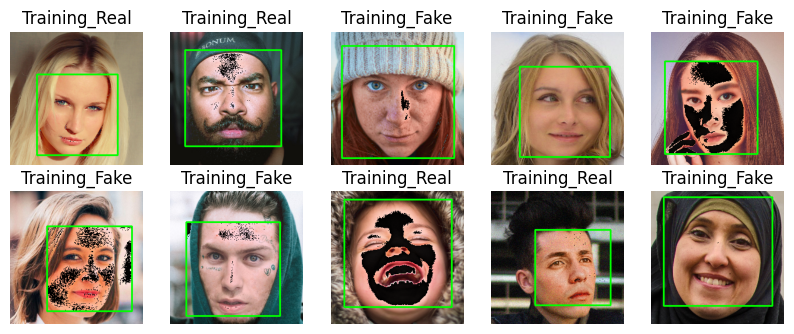

In [16]:
visualize_img(x, labels)

In [17]:
def save_processed_images(x, labels, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    for image, label in zip(x, labels):
        class_folder = os.path.join(output_dir, str(label))
        os.makedirs(class_folder, exist_ok=True)
        
        filename = f'image_{str(label)}_{len(os.listdir(class_folder))}.jpg'
        filepath = os.path.join(class_folder, filename)
        cv2.imwrite(filepath, image)

In [18]:
processed_image = '/content/drive/MyDrive/processed_image'

In [19]:
processed_image = save_processed_images(x, labels, processed_image)

In [20]:
#Train veri seti için bir generator tanımlıyoruz
train = ImageDataGenerator(horizontal_flip = True,
                           validation_split = 0.2,
                           rescale = 1./255,
                           shear_range = 0.2,
                           zoom_range = 0.2,
                           width_shift_range = 0.1,
                           height_shift_range = 0.1)

#Test veri seti için bir generator tanımlıyoruz.
test = ImageDataGenerator(rescale = 1/255,
                          validation_split = 0.1)

In [21]:
processed_image = '/content/drive/MyDrive/processed_image'

In [22]:
train_generator = train.flow_from_directory(directory = processed_image,
                                             target_size = (target_size),
                                             class_mode = 'binary',
                                             subset = 'training')

test_generator = test.flow_from_directory(directory = processed_image,
                                          target_size = (target_size),
                                          batch_size = 251,
                                          class_mode = 'binary',
                                          subset = 'validation')

Found 1633 images belonging to 2 classes.
Found 204 images belonging to 2 classes.


In [23]:
#modelleme
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=1, activation='sigmoid'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        

In [25]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.Accuracy()])

In [26]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
             ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=1)]

In [27]:
history = model.fit_generator(generator=train_generator,
                              epochs=30,
                              validation_data=test_generator,
                              callbacks=callbacks,
                              workers=4,
                              steps_per_epoch=1633//32,
                              validation_steps=204//32)

Epoch 1/30
51/51 [==============================] - ETA: 0s - loss: 1.2852 - precision: 0.4475 - recall: 0.4356 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 1.02808, saving model to mymodel.h5
51/51 [==============================] - 36s 420ms/step - loss: 1.2852 - precision: 0.4475 - recall: 0.4356 - accuracy: 0.0000e+00 - val_loss: 1.0281 - val_precision: 0.3788 - val_recall: 0.2604 - val_accuracy: 0.0000e+00
Epoch 2/30
51/51 [==============================] - ETA: 0s - loss: 0.8506 - precision: 0.4957 - recall: 0.5338 - accuracy: 0.0000e+00
Epoch 2: val_loss did not improve from 1.02808
51/51 [==============================] - 19s 351ms/step - loss: 0.8506 - precision: 0.4957 - recall: 0.5338 - accuracy: 0.0000e+00 - val_loss: 1.0361 - val_precision: 0.4422 - val_recall: 0.6771 - val_accuracy: 0.0000e+00
Epoch 3/30
51/51 [==============================] - ETA: 0s - loss: 0.7800 - precision: 0.4808 - recall: 0.3646 - accuracy: 0.0000e+00
Epoch 3: val_loss improved fr

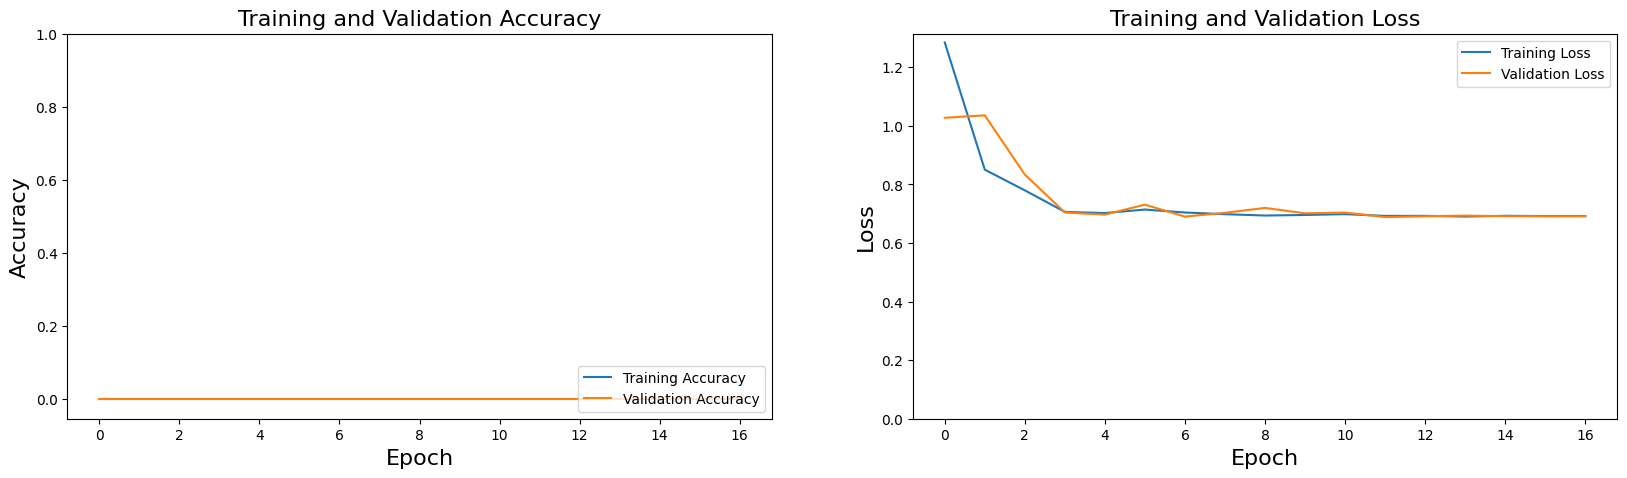

In [28]:
# Accuracy Grafiği
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy', fontsize=16)

# Loss grafiği
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)

plt.show()


In [29]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)

1/1 [==============================] - 1s 887ms/step - loss: 0.6914 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.0000e+00


In [30]:
print("\nTest accuracy: %.1f%%" % (100.0 * acc))
print("\nTest loss: %.1f%%" % (100.0 * loss))
print("\nTest precision: %.1f%%" % (100.0 * precision))
print("\nTest recall: %.1f%%" % (100.0 * recall))


Test accuracy: 0.0%

Test loss: 69.1%

Test precision: 0.0%

Test recall: 0.0%


In [31]:
from sklearn.metrics import classification_report

x_test, y_test = test_generator.next()

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Sınıflandırma raporu hesaplama
report = classification_report(np.round(y_test), y_pred)
print(report)

7/7 [==============================] - 0s 52ms/step
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69       108
         1.0       0.00      0.00      0.00        96

    accuracy                           0.53       204
   macro avg       0.26      0.50      0.35       204
weighted avg       0.28      0.53      0.37       204



In [32]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [33]:
target_names = list(waste_labels.keys())

In [34]:
#Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(8,6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label', fontweight="bold")
  plt.xlabel('Predicted label', fontweight="bold")

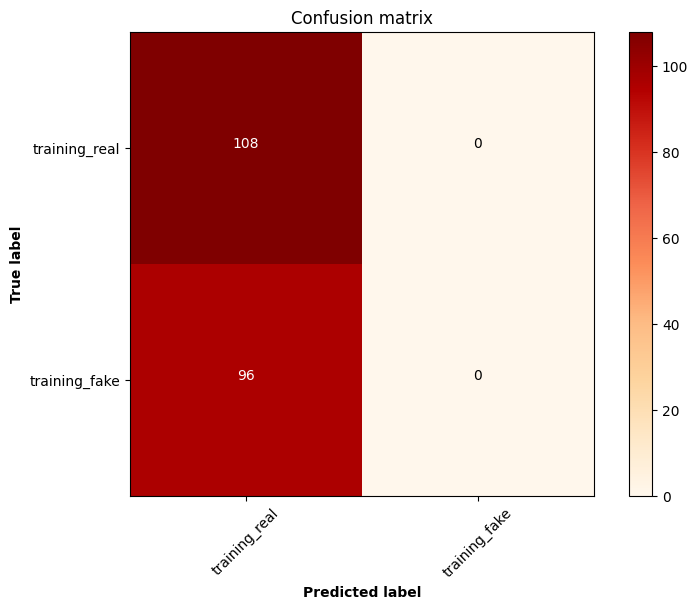

In [35]:
plot_confusion_matrix(cm, waste_labels.keys(),
                      title='Confusion matrix',
                      cmap=plt.cm.OrRd)